In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET 4 : Segmentation des clients d'un site e-commerce

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
## [MISSION 1: DIFFERENTS TYPES DE SEGMENTATION ](#5)<a class="anchor" id="sommaire"></a>
### [M1-1 : RFM](#6)<a class="anchor" id="sommaire"></a>
#### [M1-1-1 : Préparation des données](#7)<a class="anchor" id="sommaire"></a>
#### [M1-1-2 : Segmentation RFM](#8)<a class="anchor" id="sommaire"></a>
### [M1-2 : K-MEANS](#9)<a class="anchor" id="sommaire"></a>
#### [M1-2-1 : Segmentation k-means avec les variables RFM](#10)<a class="anchor" id="sommaire"></a>
#### [M1-2-2 : Segmentation k-means avec toutes des variables](#11)<a class="anchor" id="sommaire"></a>
### [M1-3 : Etudes de stabilité sur des périodes glissantes ](#16)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
import sklearn.manifold as manifold
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from utils.functions import rfm_level_type1, radar_plot, plotKmeansClustersWcss
from utils.functions import plotKmeansClusters, createFeaturesCustomersV2

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

In [4]:
# Lecture du fichier de sauvegarde de DF final
file_df = 'data/final/customers_Final_Behaviour.csv'
file_AllData = 'data/final/AllData.csv'

df = pd.read_csv(file_df, sep='\t', engine='python')
all_Data = pd.read_csv(file_AllData, sep='\t', engine='python')

In [5]:
# Supression des variables des montants par categorie
# en doublon(cf matrice de correlation) :
df.drop(columns=['amount_sports_leisure',
                 'amount_health_beauty',
                 'amount_home',
                 'amount_furniture',
                 'amount_fashion',
                 'amount_misc',
                 'amount_construction',
                 'amount_electronics',
                 'amount_supplies',
                 'amount_food_drink',
                 'amount_gifts'], inplace=True)

## [MISSION 1: DIFFERENTS TYPES DE SEGMENTATION ](#sommaire)<a class="anchor" id="5"></a>

### [M1-1 : RFM ](#sommaire)<a class="anchor" id="6"></a>

#### [M1-1-1 : Préparation des données](#sommaire)<a class="anchor" id="7"></a>

In [6]:
df_rfm = df[['customer_id', 'recency_order',
             'frequency_order', 'monetary_amount_order']].copy()
df_rfm.fillna(0, inplace=True)

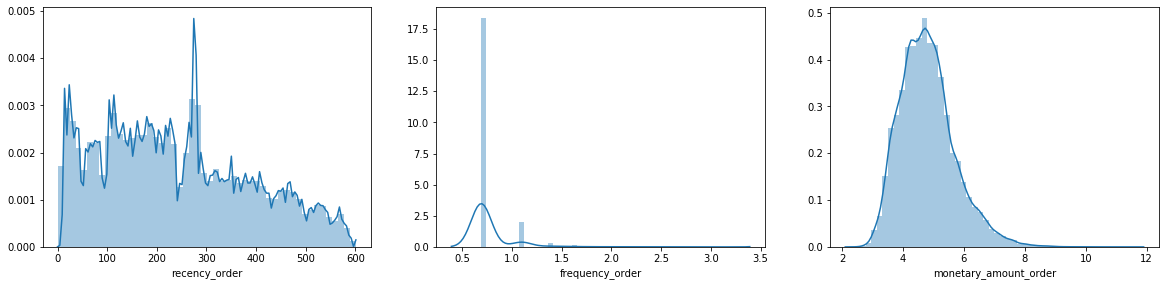

In [7]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.distplot(df_rfm['recency_order'], kde_kws={'bw': 0.1})
plt.subplot(3, 3, 2)
sns.distplot(df_rfm['frequency_order'], kde_kws={'bw': 0.1})
plt.subplot(3, 3, 3)
sns.distplot(df_rfm['monetary_amount_order'], kde_kws={'bw': 0.1})

#### Scoring en se basant sur les quartiles : 

In [8]:
# Faire une transformation inverse de la normalisation faite Log :
df_rfm_inverse = df_rfm.copy()
df_rfm_inverse['frequency_order'] =  \
    np.exp(df_rfm['frequency_order']) - 1
df_rfm_inverse['monetary_amount_order'] =  \
    np.exp(df_rfm['monetary_amount_order'])-1

In [9]:
# Calcul des score de R
df_rfm_inverse['r_percentile'] =\
    df_rfm_inverse['recency_order'].rank(method='first')
df_rfm_inverse['r_score'] = pd.qcut(df_rfm_inverse['r_percentile'],
                                    4, labels=range(4, 0, -1))

# Calcul des score de F
df_rfm_inverse['f_percentile'] =\
    df_rfm['frequency_order'].rank(method='first')
df_rfm_inverse['f_score'] = pd.qcut(df_rfm_inverse['f_percentile'],
                                    4, labels=range(1, 5, +1))

# Calcul des score de M
df_rfm_inverse['m_percentile'] = df_rfm_inverse['monetary_amount_order'].rank()
df_rfm_inverse['m_score'] = pd.qcut(df_rfm_inverse['m_percentile'],
                                    4, labels=range(1, 5, +1))

# Concatenation des scores RFM
df_rfm_inverse['rfm_concat_score'] = df_rfm_inverse['r_score'].astype(str) \
    + df_rfm_inverse['f_score'].astype(str)\
    + df_rfm_inverse['m_score'].astype(str)
# Somme des scores R+F+M
df_rfm_inverse['rfm_score'] = df_rfm_inverse['r_score'].astype(int) +  \
    df_rfm_inverse['f_score'].astype(int) + df_rfm_inverse['m_score'].astype(int)

#### [M1-1-2 : Segmentation RFM](#sommaire)<a class="anchor" id="8"></a>

Cette segmentation dependra des besoins clients donc à discuter avec le client mais voici une première repartition : 
-  Meilleurs clients -> =444 (A garder imperativement)
-  Clients fideles -> f_score = 4
-  Gros dépensiers -> m_score = 4
-  Presque perdus -> r_score <= 2 (A relancer)
-  Clients perdus (Bon consommateurs mais perdu -> voir ce qu'on peut faire)
-  Clients bon marché perdus -> 111 (Ne même pas relancer)


In [14]:
# Créer une nouvelle variable cluster pour determiner les clusters :
df_rfm_inverse['rfm_cluster'] = df_rfm_inverse.apply(rfm_level_type1, axis=1)

In [15]:
# Calcul des moyennes de chaque rfm_level et la taille de chaque segment
rfm_level_agg = df_rfm_inverse.groupby('rfm_cluster').agg({
    'recency_order': 'mean',
    'frequency_order': 'mean',
    'monetary_amount_order': ['mean', 'count']
}).round(1)
# Afficher l'agregation
print(rfm_level_agg)

                          recency_order frequency_order monetary_amount_order  \
                                   mean            mean                  mean   
rfm_cluster                                                                     
Autres clients                    111.3             1.0                  91.8   
Clients bon marché perdus         450.5             1.0                  43.3   
Clients fidèles                   112.0             1.2                 100.0   
Gros dépensiers                   260.0             1.5                 535.9   
Meilleurs clients                  59.7             2.2                 739.1   
Presque perdus                    358.2             1.0                  94.6   

                                  
                           count  
rfm_cluster                       
Autres clients             29282  
Clients bon marché perdus   1711  
Clients fidèles             6275  
Gros dépensiers            21040  
Meilleurs clients        

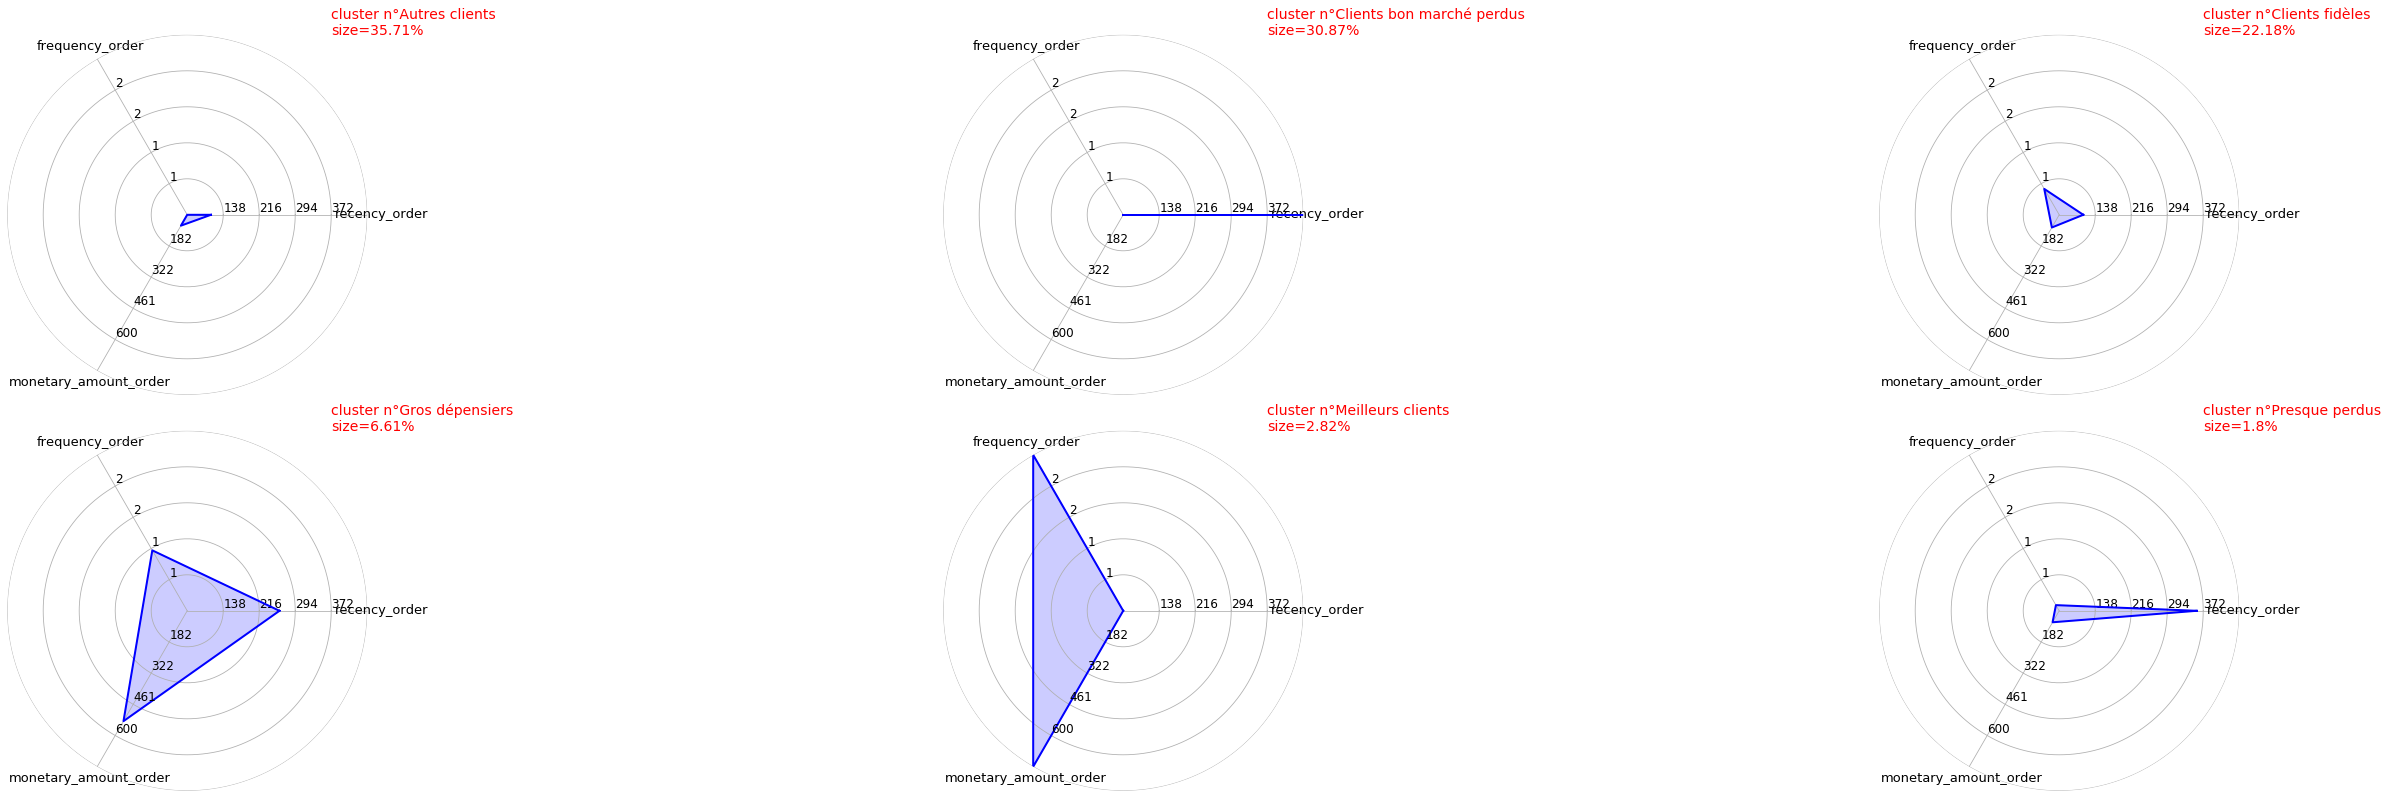

In [16]:
# Affichage des repartitions des variables selon les clusters :
cluster_rfm_df = df_rfm_inverse[['recency_order', 'frequency_order',
                                 'monetary_amount_order', 'rfm_cluster']]
radar_plot(cluster_rfm_df, group='rfm_cluster', xsize=0.1, ysize=0.05, figsize=(30, 10))

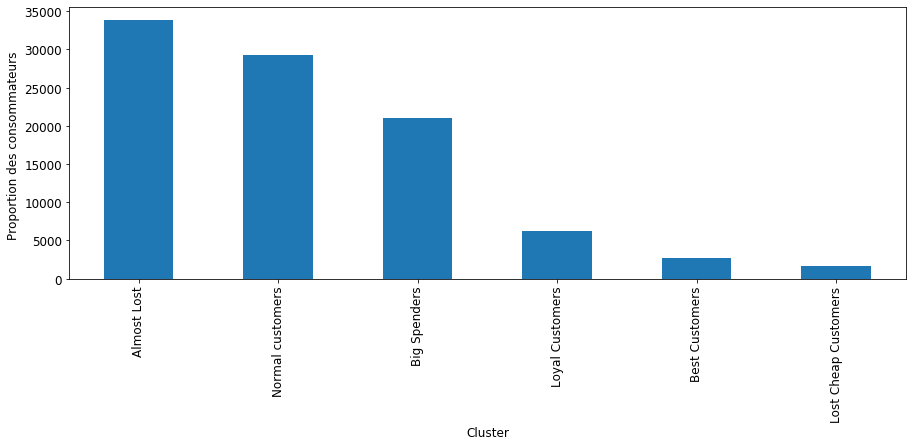

In [35]:
# Proportions  selon les cluster
ax = df_rfm_inverse['rfm_cluster'].value_counts() \
    .plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Proportion des consommateurs ", fontsize=12)
plt.show()

### [M1-2 : K-Means ](#sommaire)<a class="anchor" id="9"></a>

Le principe consiste à : 
- Determiner un intervale de nombre de cluster K (ici K entre 1 et 20) et pour chaque cluster son centre de gravité
- par itération : placer toutes les données dans les centre les plus proches et recalculer les nouveaux centres
- on arrete quand la somme des moyennes des erreurs quadratiques est stable

#### [M1-2-1 : Segmentation k-means avec les variables RFM](#sommaire)<a class="anchor" id="10"></a>

#### Préparation des données :

In [6]:
df_kmeans_rfm = df[['customer_id', 'recency_order',
                    'frequency_order', 'monetary_amount_order']].copy()
df_kmeans_rfm_in = df_kmeans_rfm.drop(columns=['customer_id'])

# Standardisation des variables d'entrée
X = df_kmeans_rfm_in.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### Recherche de nombre de clusters :

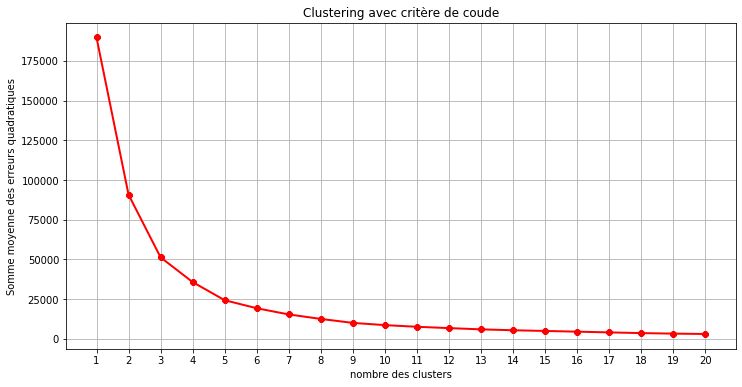

In [7]:
# Determiner les nombres de clusters  avec la methode de Elbow :
# On caclcule la somme des erreur quadratiques wcss des clusters
# pour k entre 1 et 20
# choisir la valeur de k ou wcss commence à diminuer (critère du coude)

plotKmeansClustersWcss(X_scaled[:, 1:])

 Selon le "critère du coude" : 
 Décrochement au 5em axe, puis décroissance régulière à partir du 6em axe :
 Donc nos avons ici 5 clusters
 - et on cosntate aussi l'erreur se stabilise à partir de 6

In [8]:
# Clustering pour n_cluster = 5/ n_initint=10 / max_iterint=300 (default)
kmeansrfm = KMeans(n_clusters=5)
df_kmeans_rfm_in['kmeans_rfm_cluster'] = \
    kmeansrfm.fit_predict(X_scaled[:, 1:])

In [9]:
# Faire une transformation inverse de la normalisation faite Log :
df_kmeans_rfm_inverse = df_kmeans_rfm_in.copy()
df_kmeans_rfm_inverse_copy = df_kmeans_rfm_inverse.copy()
# Les variables qui ont un coeeficient de skewness > 2
listVarDensite = ['monetary_amount_order']

for j, val in enumerate(listVarDensite):
    # Transformer les données pour le rendre normales
    df_kmeans_rfm_inverse_copy[val] = np.exp(df_kmeans_rfm_inverse[val])-1
    jmax = j
# df_kmeans_inverse_copy.shape

#### Répartition des variables pour chaque cluster :

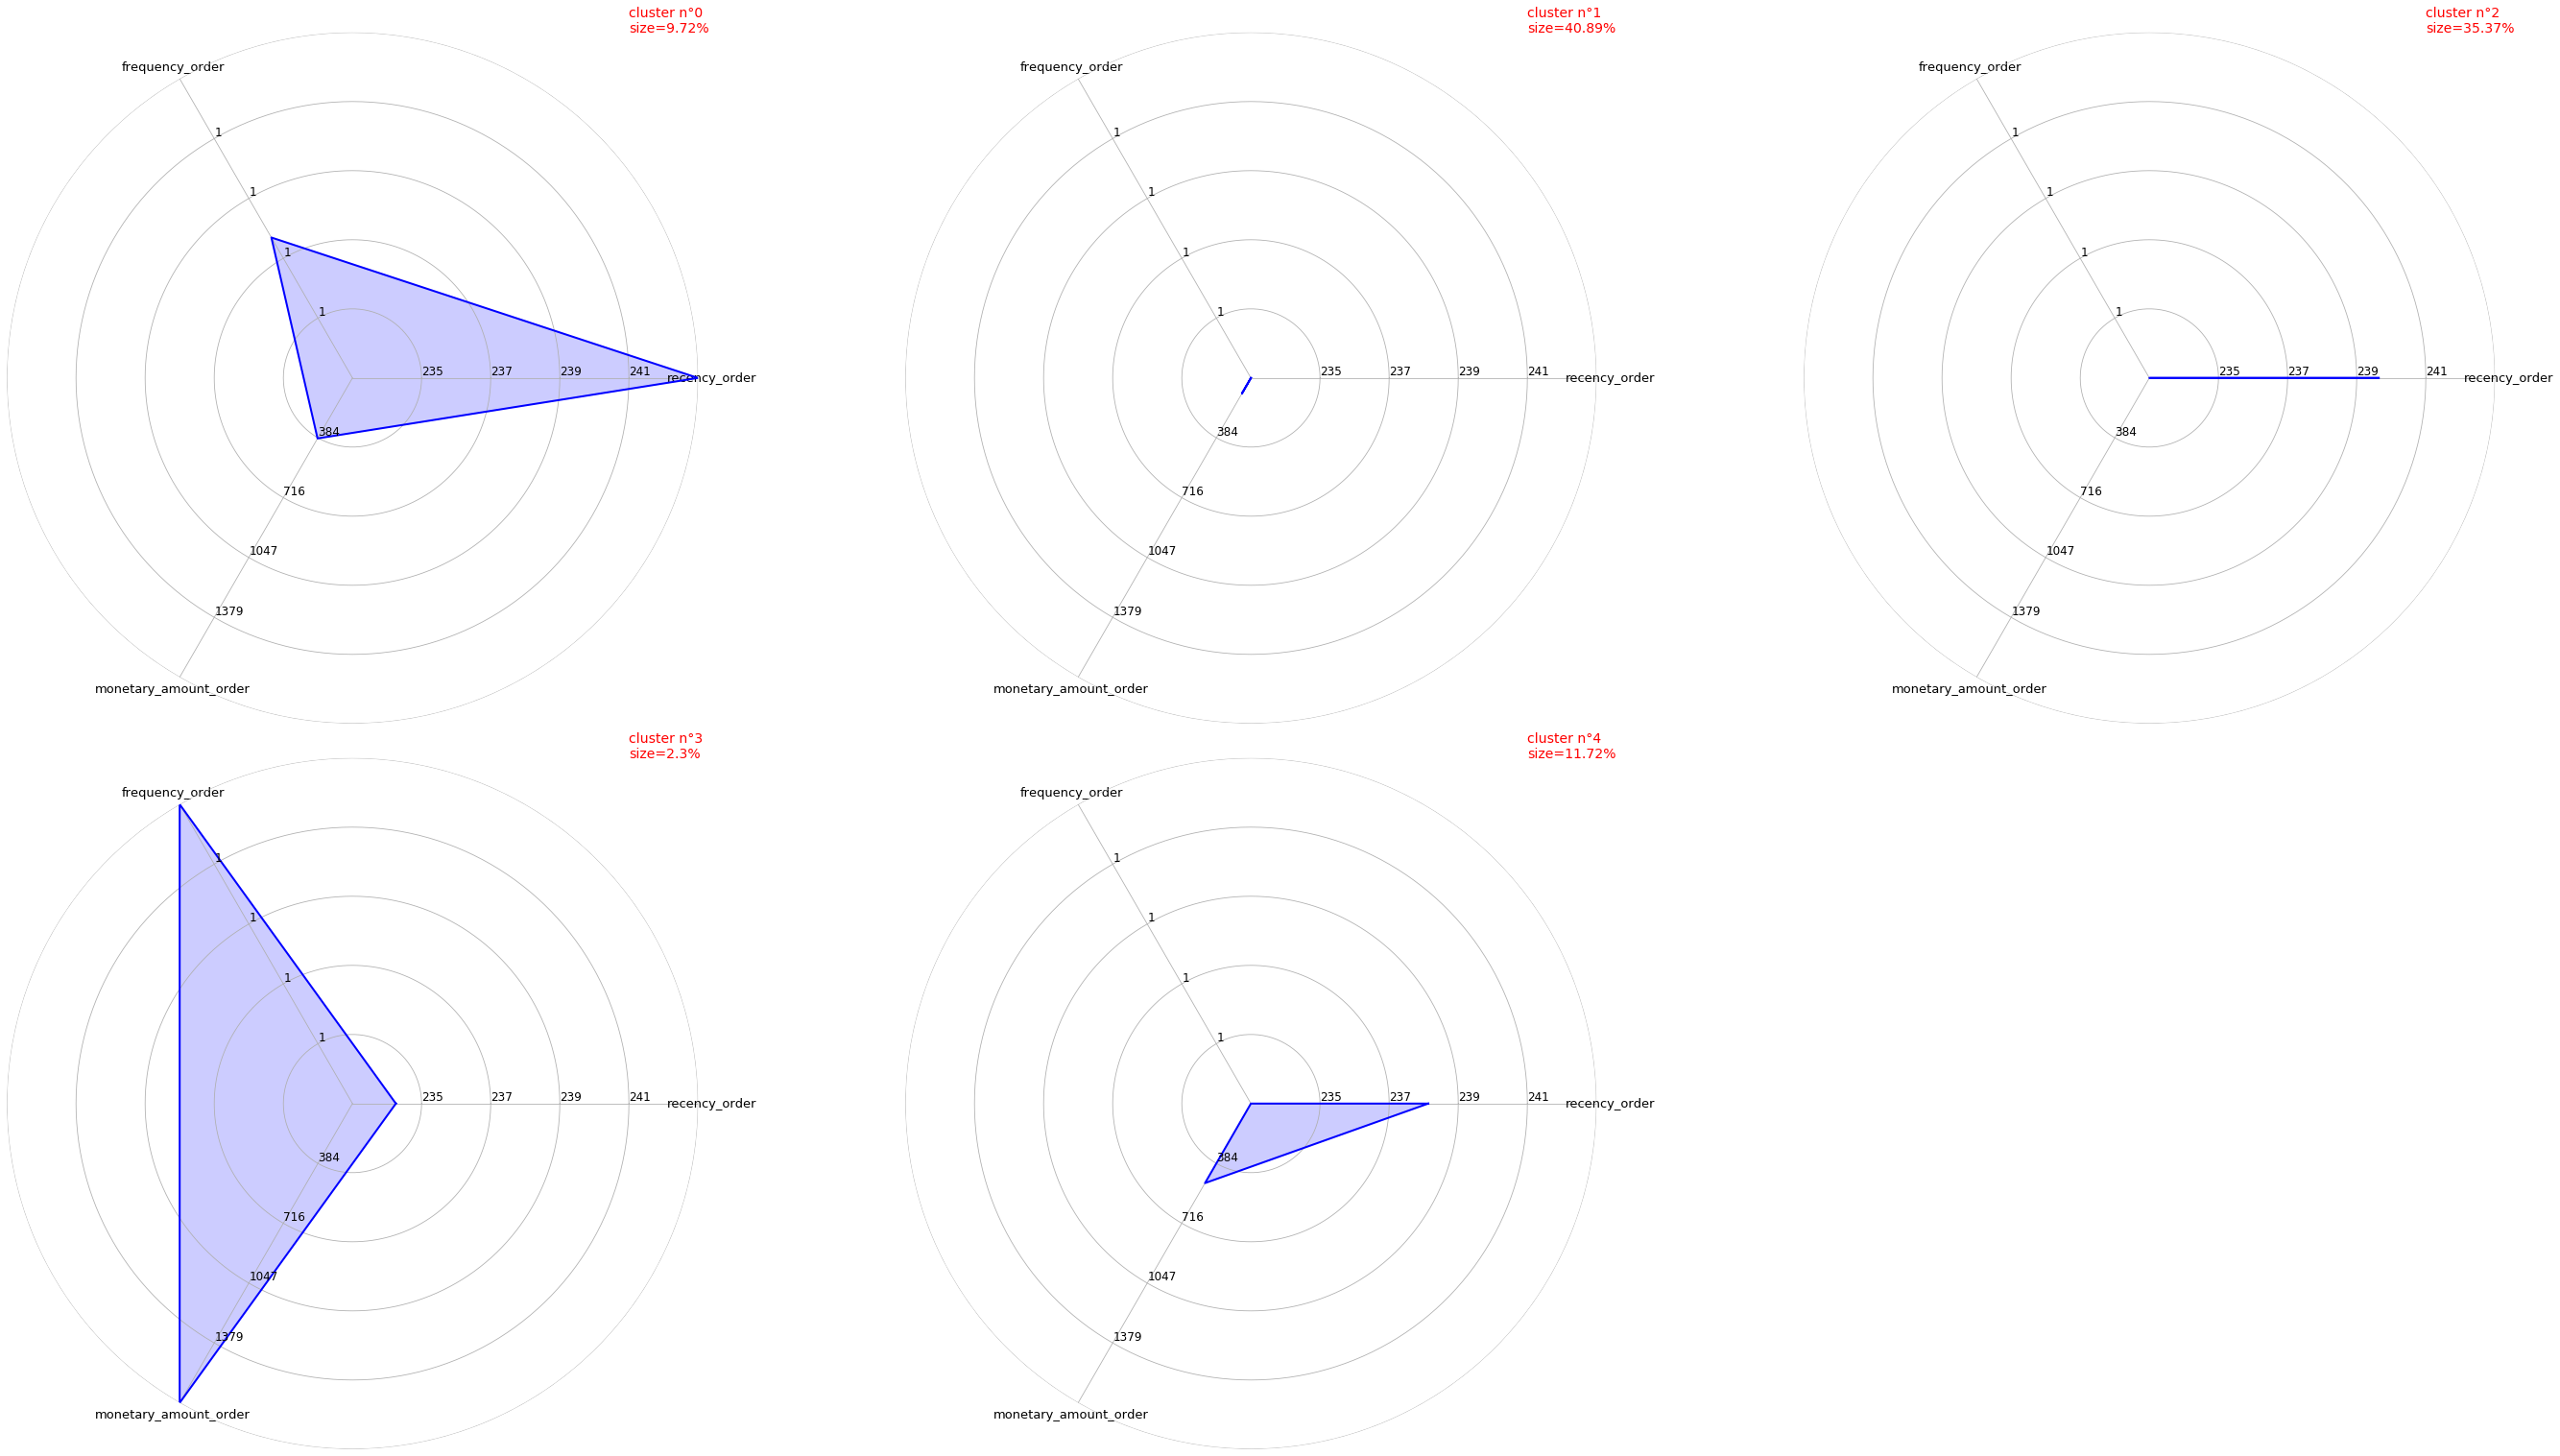

In [25]:
# Affichage des repartitions des variables pour chaque cluster :
radar_plot(df_kmeans_rfm_inverse_copy, group='kmeans_rfm_cluster', xsize=0.1, ysize=0.05, figsize=(30, 10))

In [14]:
# On constate que la fréquence est toujours à 1

#### Représentation graphique des clusters avec T-SNE :

Etant donné que nous dans un cas de problème non-linéaire, j'ai choisile T-SNE pour representer graphiquement les clusters.

In [15]:
kmeansrfm.fit(X_scaled)
kmeansrfm_cluster = kmeansrfm.predict(X_scaled)

np.random.seed(1)
tsne_kmeans_rfm_sample = df_kmeans_rfm_in

# On applique le T-SNE à l'échantillon
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(tsne_kmeans_rfm_sample)

l'option init=’pca’ permet de conserver de base un peu plus de la structure globale pour la visualisation
perplexity definira : nbr effectif de voisin, representation entre espace globale et locale, cluster

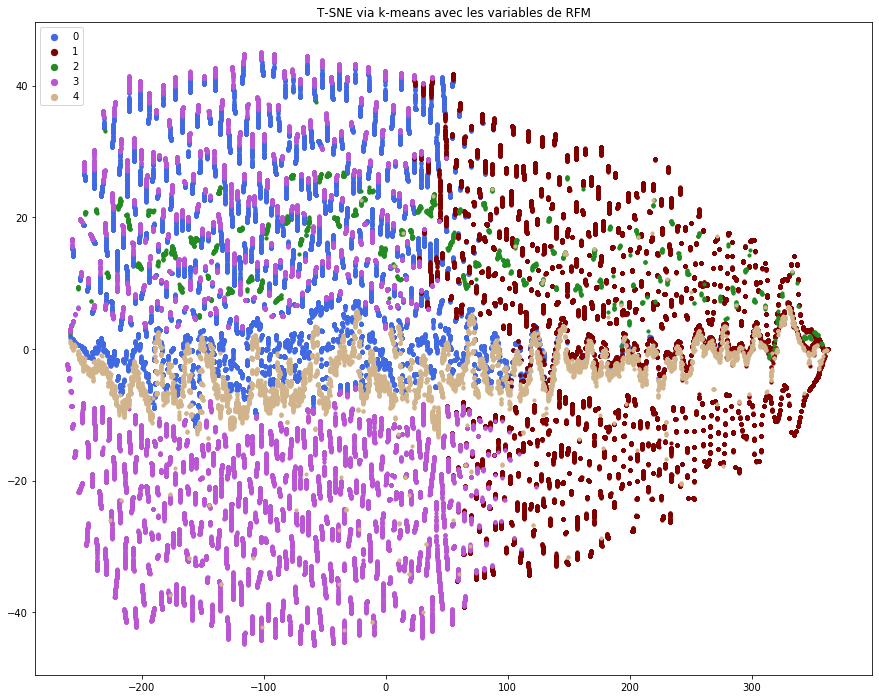

In [16]:
from utils.functions import plotKmeansClusters
# Affichage du graphique
clusters_sample = kmeansrfm_cluster
plotKmeansClusters(clusters_sample, X_tsne)

#### Qualité de clustering :

La qualité de d'un clustering est determinée par :
- homogeneité des points dans un cluster(resserrés sur eux mêmes)
- la distance de séparation entre les clusters doit etre grand(loin les uns des autres)

Ces deux mesures sont combinées dans le coefficient de silhouette moyen compris entre [-1,1], plus on se rapproche de 1, la prédiction de cluster pour un point est meilleure.

In [28]:
# Calcul de Silhouette_Score
#
score_kmeansrfm = silhouette_score(X_scaled,
                                   kmeansrfm.labels_,
                                   metric='euclidean')
# Print the score
print('Silhouette Score: %.3f' % score_kmeansrfm)

Silhouette Score: 0.361


#### [M1-2-1 : Segmentation k-means avec toutes les variables quantitatives : ](#sommaire)<a class="anchor" id="11"></a>

#### Préparation des données :

In [31]:
# df.info()

In [38]:
df_kmeans = df.copy()
df_kmeans_in = df_kmeans.drop(columns=['Unnamed: 0', 'customer_id',
                                       'customer_unique_id', 'customer_city',
                                       'customer_state',
                                       'First_order_date', 'order_id'])
df_kmeans_in.fillna(0, inplace=True)

In [39]:
# Standardisation des variables :
df_kmeans_std = df_kmeans_in.copy()

Xkmeans = df_kmeans_std.values

std_scalekmeans = preprocessing.StandardScaler().fit(Xkmeans)
X_scaledkmeans = std_scalekmeans.transform(Xkmeans)

#### Recherche de nombre de clusters :

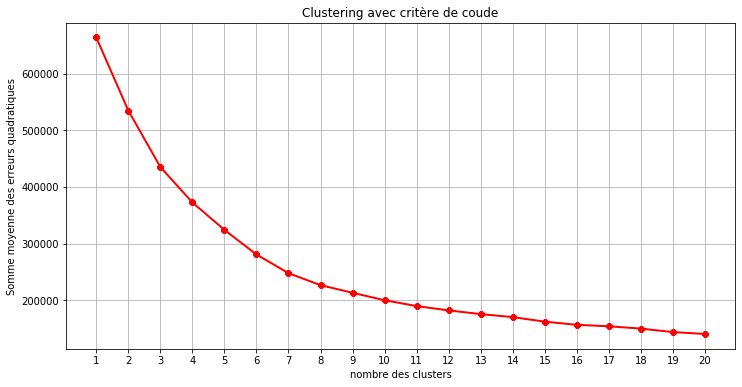

In [20]:
# Determiner les nombres de clusters  avec la methode de Elbow :
# On caclcule la somme des erreur quadratiques wcss des clusters
# pour k entre 1 et 20
# choisir la valeur de k ou wcss commence à diminuer (critère du coude)
plotKmeansClustersWcss(X_scaledkmeans[:, 1:])

In [26]:
# Selon le "critère du coude" : 
# Décrochement au 6em axe, puis décroissance régulière à partir du 7em axe :
# Donc nos avons ici 7 clusters

#### Générer les clusters :

In [35]:
# df_kmeans_in

In [40]:
# Clustering pour n_cluster = 7
kmeans = KMeans(n_clusters=7)
df_kmeans_in['kmeans_cluster'] = kmeans.fit_predict(X_scaledkmeans[:, 1:])

# Faire une transformation inverse de la normalisation faite Log :
df_kmeans_inverse = df_kmeans_in.copy()
df_kmeans_inverse_copy = df_kmeans_inverse.copy()
listVarDensite = ['frequency_order',
                  'monetary_amount_order',
                  'mean_value_order', 'nbr_payments_type']

for j, val in enumerate(listVarDensite):
    # Transformer les données pour le rendre normales
    # Les variables qui ont un coeeficient de skewness > 2
    df_kmeans_inverse_copy[val] = np.exp(df_kmeans_inverse[val])-1
    jmax = j

#### Répartition des variables pour chaque cluster :

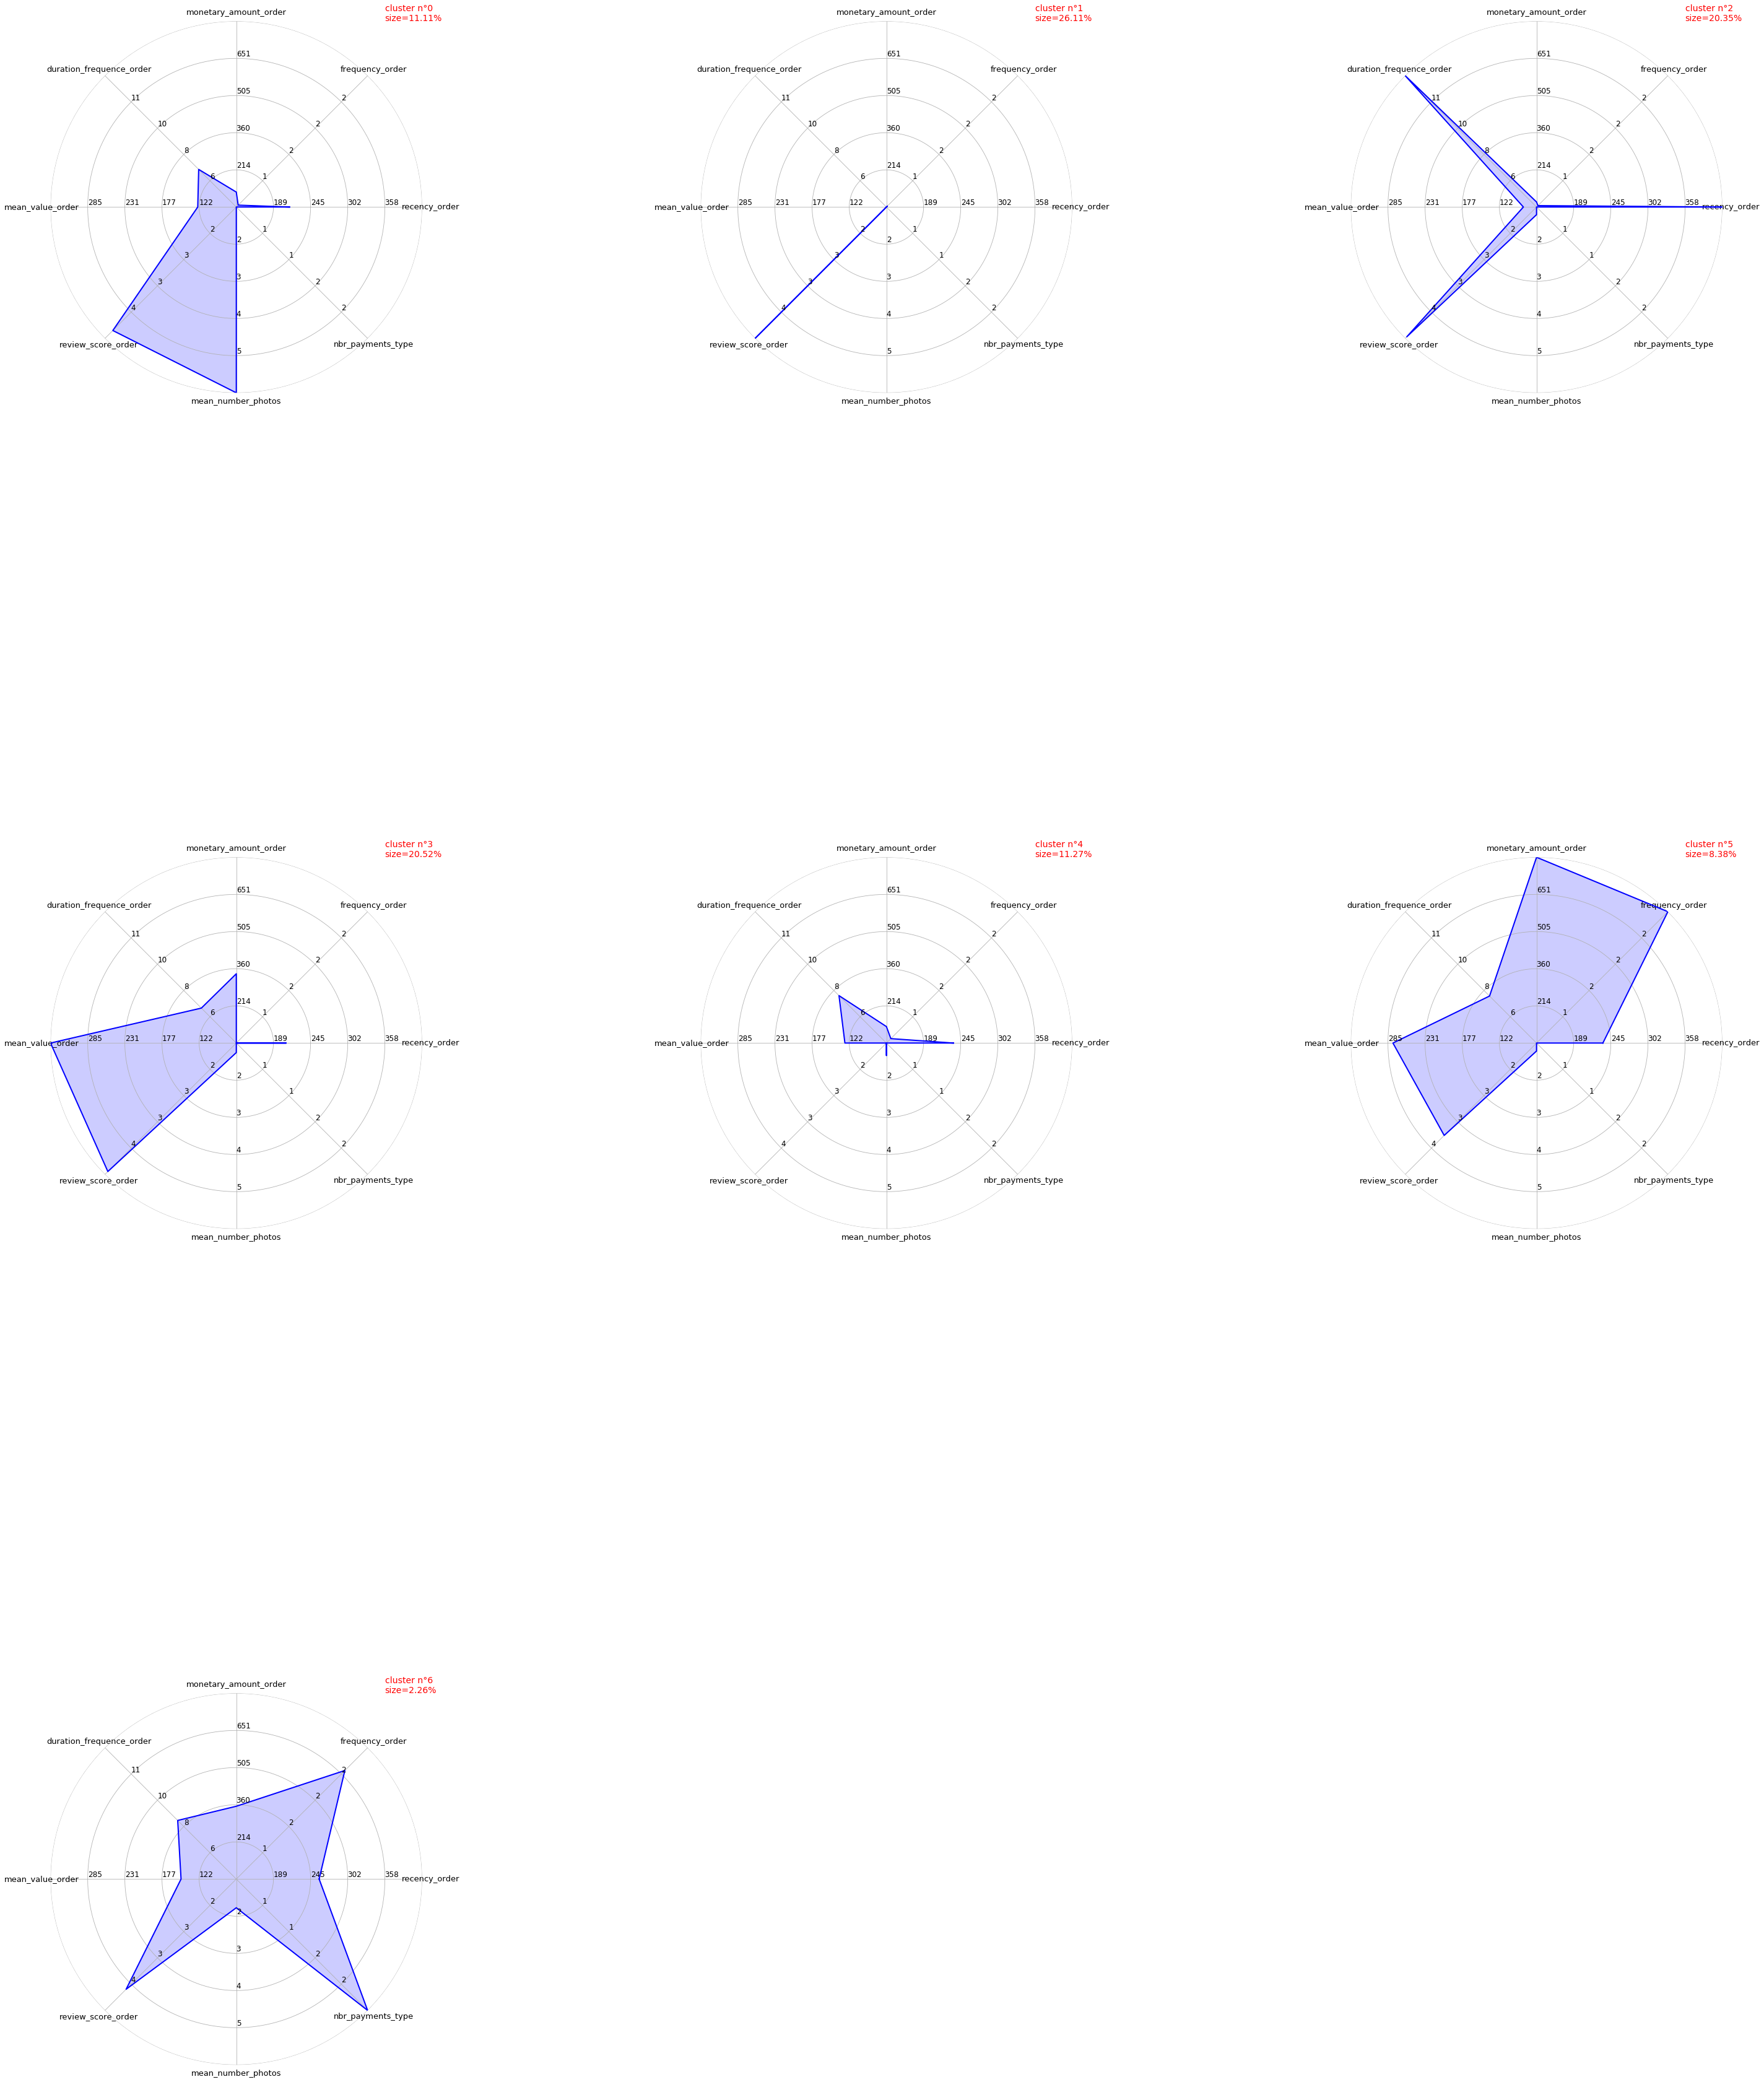

In [41]:
# Affichage des repartitions des variables pour chaque cluster :
radar_plot(df_kmeans_inverse_copy, group='kmeans_cluster',
           xsize=0.25, ysize=0.25, figsize=(25, 25))

#### Personas marketing des consommateurs :

#### Représentation graphique des clusters avec T-SNE :

In [38]:
kmeans.fit(X_scaledkmeans)
kmeans_cluster = kmeans.predict(X_scaledkmeans)

# Réduction des dimensions pour afficher les clusters :
np.random.seed(1)
tsne_sample = df_kmeans_in

# On applique le T-SNE à l'échantillon
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(tsne_sample)

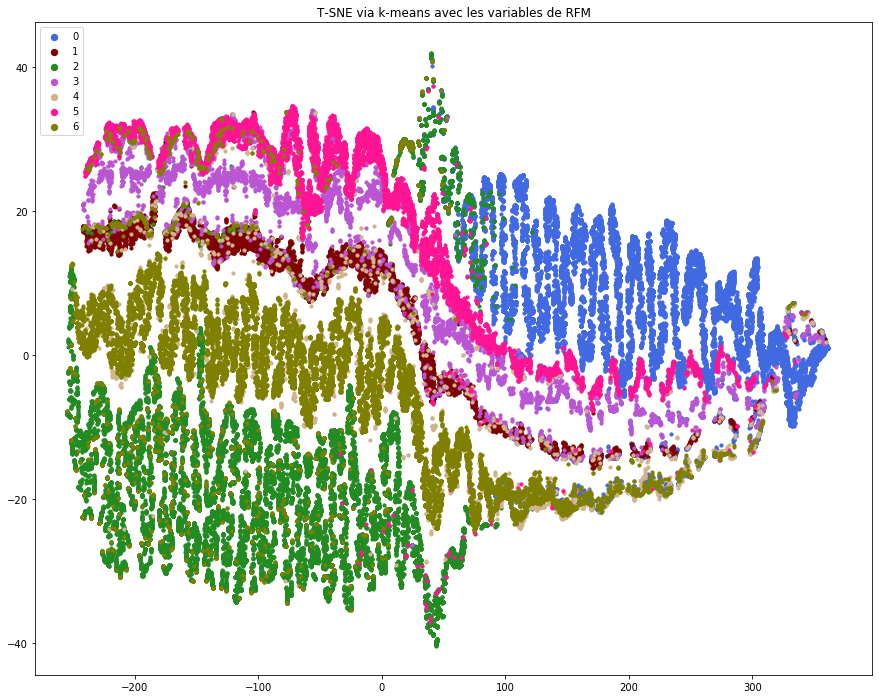

In [39]:
# Affichage du graphique
clusters_sample = kmeans_cluster
plotKmeansClusters(clusters_sample, X_tsne)

#### Qualité de clustering : 

La qualité de d'un clustering est determinée par :
- homogeneité des points dans un cluster(resserrés sur eux mêmes)
- la distance de séparation entre les clusters doit etre grand(loin les uns des autres)

Ces deux mesures sont combinées dans le coefficient de silhouette moyen compris entre [-1,1], plus on se rapproche de 1, la prédiction de cluster pour un point est meilleure.

In [41]:
# Calcul de Silhouette_Score
score_kmeans = silhouette_score(X_scaledkmeans,
                                kmeans.labels_,
                                metric='euclidean')
# Print the score
print('Silhouette Score: %.3f' % score_kmeans)

Silhouette Score: 0.254


3:48: W291 trailing whitespace





#### Conclusion :

Les methodes ont sensiblement les même scores mais étant donné que la plupart des clients n'ont commandé qu'une fois sur le site, ce ne serait pas ideal de n'avoir que 3 variables RFM.

Donc mon choix se porte sur la methode k-means avec plus des variables.

### [M1-3 : Etudes de stabilité sur des périodes glissantes : ](#sommaire)<a class="anchor" id="16"></a>

#### Stabilité de clustering :

La stabilité est determinée par : 
-  si je lance l'algorithme plusieurs fois sur les mêmes données avec une initialisation différente, ou sur des sous-ensembles différents des données, est ce que j'obtiens les mêmes résultats ??

    L'indice de Rand Ajusté (ARI) permet de determiner cette stabilité, sa valeur comprise entre [0,1], proche de 0 pour un clustering aléatoire et et 1 quand le clustering est correpond exactement à la partition initiale. 

Les données à notre disposition sont de janvier 2017 à Août 2018.
Donc nous allons prendre en réference les données de janvier 2017 à décembre 2017 pour entrainer notre algorithme
puis nous allons prédire les clusters sur les périodes glissantes par mois de un an jusqu'en août 2018 et voir l'evolution du score si on ne met pas à jour les données d'entrainement. 

#### Constituer les données de référence et les données glissantes :

In [17]:
# Constituer les données de références 
df_Reference = createFeaturesCustomersV2(all_Data,
                                         '2017-01-01 00:00:00',
                                         '2018-01-01 00:00:00')
df_Reference_in = df_Reference.drop(columns=['customer_id'])
# Standardisation
X_Ref = df_Reference_in.values
stdRef_scale = preprocessing.StandardScaler().fit(X_Ref)
X_Ref_scaled = stdRef_scale.transform(X_Ref)

# Constituer les données de M+1 
df_M1 = createFeaturesCustomersV2(all_Data,
                                  '2017-02-01 00:00:00',
                                  '2018-02-01 00:00:00')
df_M1_in = df_M1.drop(columns=['customer_id'])
# Standardisation
X_M1 = df_M1_in.values
stdM1_scale = preprocessing.StandardScaler().fit(X_M1)
X_M1_scaled = stdM1_scale.transform(X_M1)

# Constituer les données de M+2 
df_M2 = createFeaturesCustomersV2(all_Data,
                                  '2017-03-01 00:00:00',
                                  '2018-03-01 00:00:00')
df_M2_in = df_M2.drop(columns=['customer_id'])
# Standardisation
X_M2 = df_M1_in.values
stdM2_scale = preprocessing.StandardScaler().fit(X_M2)
X_M2_scaled = stdM2_scale.transform(X_M2)

# Constituer les données de M+3
df_M3 = createFeaturesCustomersV2(all_Data,
                                  '2017-04-01 00:00:00',
                                  '2018-04-01 00:00:00')
df_M3_in = df_M3.drop(columns=['customer_id'])
# Standardisation
X_M3 = df_M3_in.values
stdM3_scale = preprocessing.StandardScaler().fit(X_M3)
X_M3_scaled = stdM3_scale.transform(X_M3)

# Constituer les données de M+4
df_M4 = createFeaturesCustomersV2(all_Data,
                                  '2017-05-01 00:00:00',
                                  '2018-05-01 00:00:00')
df_M4_in = df_M4.drop(columns=['customer_id'])
# Standardisation
X_M4 = df_M4_in.values
stdM4_scale = preprocessing.StandardScaler().fit(X_M4)
X_M4_scaled = stdM4_scale.transform(X_M4)

# Constituer les données de M+5 
df_M5 = createFeaturesCustomersV2(all_Data,
                                  '2017-06-01 00:00:00',
                                  '2018-06-01 00:00:00')
df_M5_in = df_M5.drop(columns=['customer_id'])
# Standardisation
X_M5 = df_M5_in.values
stdM5_scale = preprocessing.StandardScaler().fit(X_M5)
X_M5_scaled = stdM5_scale.transform(X_M5)

# Constituer les données de M+6
df_M6 = createFeaturesCustomersV2(all_Data,
                                  '2017-07-01 00:00:00',
                                  '2018-07-01 00:00:00')
df_M6_in = df_M6.drop(columns=['customer_id'])
# Standardisation
X_M6 = df_M6_in.values
stdM6_scale = preprocessing.StandardScaler().fit(X_M6)
X_M6_scaled = stdM6_scale.transform(X_M6)

# Constituer les données de M+7
df_M7 = createFeaturesCustomersV2(all_Data,
                                  '2017-08-01 00:00:00',
                                  '2018-08-01 00:00:00')
df_M7_in = df_M7.drop(columns=['customer_id'])
# Standardisation
X_M7 = df_M7_in.values
stdM7_scale = preprocessing.StandardScaler().fit(X_M7)
X_M7_scaled = stdM7_scale.transform(X_M7)

# Constituer les données de M+8
df_M8 = createFeaturesCustomersV2(all_Data,
                                  '2017-09-01 00:00:00',
                                  '2018-09-01 00:00:00')
df_M8_in = df_M8.drop(columns=['customer_id'])
# Standardisation
X_M8 = df_M8_in.values
stdM8_scale = preprocessing.StandardScaler().fit(X_M8)
X_M8_scaled = stdM8_scale.transform(X_M8)

1:39: W291 trailing whitespace
11:32: W291 trailing whitespace
21:32: W291 trailing whitespace
51:32: W291 trailing whitespace


#### Entraîner avec les données de réference :

In [19]:
kmeans0 = KMeans(n_clusters=7).fit(X_Ref_scaled)
labels0 = kmeans0.labels_
# print(labels0)

#### Prédire les clusters pour les autres périodes avec la période de réference en entraînement :

In [20]:
pred1 = kmeans0.predict(X_M1_scaled)
pred2 = kmeans0.predict(X_M2_scaled)
pred3 = kmeans0.predict(X_M3_scaled)
pred4 = kmeans0.predict(X_M4_scaled)
pred5 = kmeans0.predict(X_M5_scaled)
pred6 = kmeans0.predict(X_M6_scaled)
pred7 = kmeans0.predict(X_M7_scaled)
pred8 = kmeans0.predict(X_M8_scaled)

#### Prédiction en entraînant sur i-eme période :

In [21]:
kmeans1 = KMeans(n_clusters=7).fit(X_M1_scaled)
pred1_test = kmeans1.predict(X_M1_scaled)

kmeans2 = KMeans(n_clusters=7).fit(X_M2_scaled)
pred2_test = kmeans2.predict(X_M2_scaled)

kmeans3 = KMeans(n_clusters=7).fit(X_M3_scaled)
pred3_test = kmeans3.predict(X_M3_scaled)

kmeans4 = KMeans(n_clusters=7).fit(X_M4_scaled)
pred4_test = kmeans4.predict(X_M4_scaled)

kmeans5 = KMeans(n_clusters=7).fit(X_M5_scaled)
pred5_test = kmeans5.predict(X_M5_scaled)

kmeans6 = KMeans(n_clusters=7).fit(X_M6_scaled)
pred6_test = kmeans6.predict(X_M6_scaled)

kmeans7 = KMeans(n_clusters=7).fit(X_M7_scaled)
pred7_test = kmeans7.predict(X_M7_scaled)

kmeans8 = KMeans(n_clusters=7).fit(X_M8_scaled)
pred8_test = kmeans8.predict(X_M8_scaled)

Le metrics.adjusted_rand_score() compare le partitionnement obtenu par la classification automatique (étiquettes de groupe de pred) avec le partitionnement correspondant aux groupes définis au départ (étiquettes stockées dans labels).

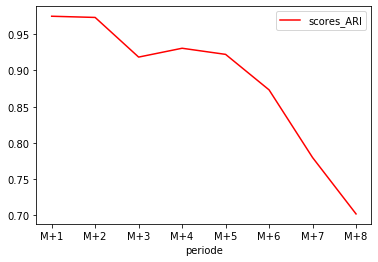

<Figure size 1440x720 with 0 Axes>

In [34]:
score_RandAdjuted_df = pd.DataFrame({
    'periode': ['M+1', 'M+2', 'M+3', 'M+4', 'M+5', 'M+6', 'M+7', 'M+8'],
    'scores_ARI': [adjusted_rand_score(pred1, pred1_test),
                   adjusted_rand_score(pred2, pred2_test),
                   adjusted_rand_score(pred3, pred3_test),
                   adjusted_rand_score(pred4, pred4_test),
                   adjusted_rand_score(pred5, pred5_test),
                   adjusted_rand_score(pred6, pred6_test),
                   adjusted_rand_score(pred7, pred7_test),
                   adjusted_rand_score(pred8, pred8_test)]})
score_RandAdjuted_df
ax = plt.gca()
score_RandAdjuted_df.plot(kind='line', x='periode',
                          y='scores_ARI', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

In [22]:
print('Score Rand Ajusté M 1 :', adjusted_rand_score(pred1, pred1_test))
print('Score Rand Ajusté M 2 :', adjusted_rand_score(pred2, pred2_test))
print('Score Rand Ajusté M 3 :', adjusted_rand_score(pred3, pred3_test))
print('Score Rand Ajusté M 4 :', adjusted_rand_score(pred4, pred4_test))
print('Score Rand Ajusté M 5 :', adjusted_rand_score(pred5, pred5_test))
print('Score Rand Ajusté M 6 :', adjusted_rand_score(pred6, pred6_test))
print('Score Rand Ajusté M 7 :', adjusted_rand_score(pred7, pred7_test))
print('Score Rand Ajusté M 8 :', adjusted_rand_score(pred8, pred8_test))

Score Rand Ajusté M 1 : 0.9747302565703145
Score Rand Ajusté M 2 : 0.973081929167044
Score Rand Ajusté M 3 : 0.9184056871166554
Score Rand Ajusté M 4 : 0.930590260560571
Score Rand Ajusté M 5 : 0.9221514250510398
Score Rand Ajusté M 6 : 0.8731884956233479
Score Rand Ajusté M 7 : 0.7799045379430425
Score Rand Ajusté M 8 : 0.7021315557596851


Nous constatons que le score de l'algorithme se degrade petit à petit.
A partir du 6eme mois le score est en dessous de 0.90

Donc ce qu'on peut proposer est de faire une maintenance tous les six mois par exemple au mois de Novembre et au mois de Mai pour s'assurer que nous avons des données d'entrainement à jour avant les pics de vente du mois de dec et juillet.